In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

In [145]:
import threading
import optparse
from pathlib import Path

import cv2
import pandas as pd
import numpy as np
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from keras.losses import mean_squared_error, logcosh, mean_absolute_error
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

from model import mobnet
from generator import generator

# Portrait Analysis

In [7]:
dset_path = Path('../gazecapture')
dset_df = 'portrait'

shape = (667, 375, 3)
lr = 1e-3
optim = RMSprop(lr)
loss = logcosh
BATCH_SIZE = 16

train = pd.read_csv('init-dataresults/{}-data/{}-traindf.csv'.format(dset_df, dset_df))

In [3]:
model = mobnet(shape, None)
model.compile(loss = loss,
            optimizer = optim)
# model.load_weights('{}-data/weights/0.002-RMSprop-logcosh.hdf5'.format(dset_df))
model.load_weights('{}-data/1-38-test.hdf5'.format(dset_df))

In [6]:
y_preds = model.predict_generator(generator=train_generator(train, shape, BATCH_SIZE, dset_path, shuffle=False),
                         steps=np.ceil(float(len(train)) / float(BATCH_SIZE)),
                         verbose=1)

41539/41539 [==============================] - 7565s 182ms/step


In [124]:
# with open('y_preds.pkl', 'wb') as f:
#     pkl.dump(y_preds, f)

In [8]:
with open('init-dataresults/y_preds.pkl', 'rb') as f:
    y_preds = pkl.load(f)

In [9]:
XCam = train['XCam'].values
YCam = train['YCam'].values
y_true = np.asarray([[xcam, ycam] for xcam, ycam in zip(XCam, YCam)])

In [10]:
diff = np.sum(np.absolute(y_true - y_preds), axis=1)

In [11]:
filenames = train['file_names'].values

In [146]:
# top k differences
k = 100000
indexs = np.argpartition(diff, -k)[-k:]
# diff[indexs]

## Manual Check

In [191]:
# cases manually found
cases_to_remove = ['02984', '02032', '01030', '01152', '00325', '02622', '00827', '02119', '00927',
                  '03277', '02190', '01282', '00808', '01474', '01805', '00207', '00666']

In [ ]:
# f, axes = plt.subplots(5, 2, figsize=(20, 20))
# i = 0
# for ax in axes.flatten():
#     image = False
#     while not image and i < k:
#         index = indexs[i]
#         fn_i = fn[index]
#         case = fn_i[:fn_i.index('/')]
#         if case not in cases_to_remove:
#             im = cv2.imread('{}/{}'.format(dset_path, fn_i))
#             ax.imshow(im)
#             ax.set_title('{}-{}'.format(fn_i, int(diff[index])))
#             image=True
#             # view a case only once
#             cases_to_remove.append(case)
#         i+=1
# plt.tight_layout()
# plt.show()

## Check # of Occurances for each Case
Checking for cases which the user is never looking at the phone, seemed to be quite a few of the manual checks

In [147]:
error = []
cases_of_poorly_predicted  = []
for i in indexs:
    fn = filenames[i]
    case = fn[:fn.index('/')]
    cases_of_poorly_predicted.append(case)
    error.append(diff[i])

In [148]:
min(error)

2.966938785552978

In [149]:
from collections import Counter

In [150]:
ccount = Counter(cases_of_poorly_predicted)

In [151]:
k = 50
kmost = ccount.most_common(k)

In [152]:
# check to see if we caught any of the top k manually
count = 0
num_frames = 0
for case, nf in kmost:
    num_frames += nf
    if case in cases_to_remove: count += 1
print("number of cases which were also found manually:", count)
print('number of frames found in total:', num_frames)

number of cases which were also found manually: 18
number of frames found in total: 16738


In [153]:
case = [case for case, _ in kmost]
count = [count for _, count in kmost]
df = pd.DataFrame(dict(case=case, count=count))

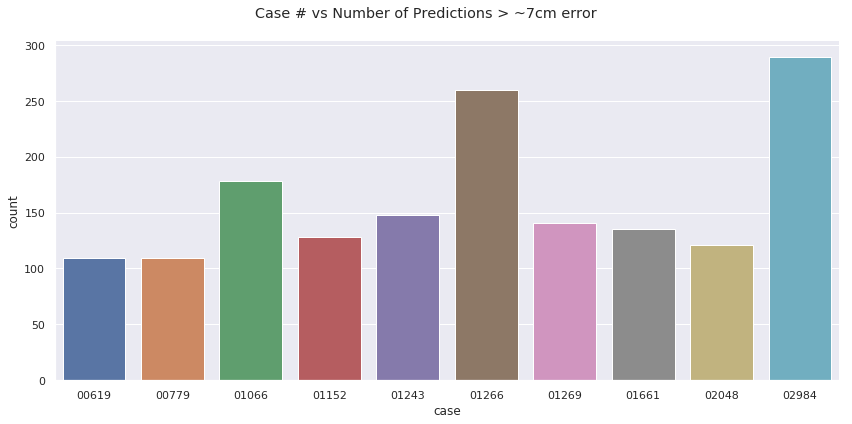

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(30,30)})
ax = sns.catplot("case", "count", data=df, kind='bar', height=6, aspect=2)
plt.subplots_adjust(top=0.9)
ax.fig.suptitle('Case # vs Number of Predictions > ~{}cm error'.format(int(min(error))))
plt.show()

In [167]:
i=0

In [192]:
cases_to_remove.extend(['01066', '01243', '01269', '01661', '02048', '01266', '00619', '00779', '01090',
                       '03059', '01432', '01225', '03060', '02781', '00138', '02526',
                       '01353', '02967', '02093', '02165'])

In [183]:
import random

In [190]:
case_i = case[i]
while case_i in cases_to_remove and i <  k:
    case_i = case[i]
    i += 1

if not (case_i in cases_to_remove) and i != k:
    print(case_i, i, count[i])
    f, axes = plt.subplots(5, 2, figsize=(20, 20))
    fnames = [str(t) for t in list((dset_path/case_i/'frames').iterdir())]
    cut_names = [int(t[t.index('.jpg')-5:t.index('.jpg')]) for t in fnames]
    cut_names.sort(key=int)
    cut_names = cut_names[:100]
    random.shuffle(cut_names)

    for ax, fn in zip(axes.flatten(), cut_names[:5*2]):
        im = img.imread(dset_path/case_i/'frames'/(format(fn, '05d')+'.jpg'))
        ax.imshow(im)
        ax.set_title('{}'.format(fn))
    i += 1
    plt.tight_layout()
    plt.show()

IndexError: list index out of range

In [194]:
cases_to_remove

['02984',
 '02032',
 '01030',
 '01152',
 '00325',
 '02622',
 '00827',
 '02119',
 '00927',
 '03277',
 '02190',
 '01282',
 '00808',
 '01474',
 '01805',
 '00207',
 '00666',
 '01066',
 '01243',
 '01269',
 '01661',
 '02048',
 '01266',
 '00619',
 '00779',
 '01090',
 '03059',
 '01432',
 '01225',
 '03060',
 '02781',
 '00138',
 '02526',
 '01353',
 '02967',
 '02093',
 '02165']